In [1]:
import dataset
from listwise_ltr import listwise_ltr
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import numpy as np

In [2]:
class ListDataSet(Dataset):
    
    def __init__(self, fold):
        self.fold = fold
    
    def __len__(self):
        return self.fold.num_queries()
    
    def __getitem__(self, index):
        return self.fold.query_feat(index), self.fold.query_labels(index)

In [3]:
torch.zeros_like(torch.zeros(4,4), requires_grad=True)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], requires_grad=True)

In [4]:
torch.range(0,4)

c:\users\ruth\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  """Entry point for launching an IPython kernel.


tensor([0., 1., 2., 3., 4.])

In [16]:
class LambdaRankLoss(torch.nn.Module):
    '''
    input: predictions and target
    output: scalar loss 
    '''
    
    def __init__(self, gamma):
        super(LambdaRankLoss, self).__init__()
        self.gamma = gamma
    
#     def forward(self, y_hat, y):
#         loss = torch.tensor(0., requires_grad=True)
#         for i, z in enumerate(y):
#             indices = torch.where(y>z)[0]
#             if len(indices) > 0:
#                 loss += torch.log(1 + torch.exp(-self.gamma * (y_hat[indices]-y_hat[i]))).sum()
                
#         return loss

    def forward(self, y_hat, y):
        loss = torch.zeros_like(y_hat)
        
        for i, z in enumerate(y):
            loss += torch.log(1 + torch.exp(-self.gamma * (y_hat-y_hat[i]))) * (y>z)
                
        return loss.sum()
    
    def backward(self, y_hat, y):
        """
        Backward pass. 
        
        Args:
            dout: gradients of the previous module
        Returns:
            dx: gradients with respect to input, weighted by
            absolute change in NDCG
        """
        
        # get |NDCG|
        dy = torch.zeros_like(y_hat)
        delta = torch.zeros_like(y_hat)
        for i, z in enumerate(y):
#             indices = torch.where(y>z)[0]
#             if len(indices) > 0:
                
            subset1 = (y_hat-y_hat[i])>0
            term = self.gamma * (1-(self.gamma*(y_hat-y_hat[i])).sigmoid())

            dy += term * subset1
            dy[i] -= term.sum()
            
            # add new positions
            delta += subset1 * (2*y[i]) / torch.log(torch.range(2,len(y_hat)+1))
            delta[i] += (subset1 * 2**y).sum() / torch.log(i+2)
            
            # remove current positions
            delta -= subset1 * (2*y) / torch.log(torch.range(2,len(y_hat)+1))
            delta[i] -= subset1.sum() * 2**y[i] / torch.log(i+2)
            
                
        return dy * torch.abs(delta)
    
    

In [17]:
N_EPOCHS = 10

In [7]:
data= dataset.get_dataset()
data = data.get_data_folds()[0]
data.read_data()



In [18]:
train_dataset = ListDataSet(data.train)
valid_dataset = ListDataSet(data.validation)
test_dataset = ListDataSet(data.test)

In [19]:
train_dl = DataLoader(train_dataset)
valid_dl = DataLoader(valid_dataset)
test_dl = DataLoader(test_dataset)

In [20]:
model = listwise_ltr.Listwise()
model.cuda()

Listwise(
  (nnet): Sequential(
    (0): Linear(in_features=501, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [21]:
optimizer = torch.optim.Adam(model.parameters())
critereon = LambdaRankLoss(gamma=1)

In [22]:
train_loss = defaultdict(list)
valid_loss = defaultdict(list)

for epoch in range(N_EPOCHS):
    
    # iterate over training set
    for ix, (X,y) in tqdm(enumerate(train_dl), total=len(train_dl)):
        X = X.cuda().float().squeeze(0)
        y = y.cuda().float().squeeze(0)
        
        
        y_hat = model(X).squeeze(1)
        
        
        
        # compute loss
        loss = critereon(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss[epoch].append(loss.item())
        
    # validate
    with torch.no_grad():
        model.eval()
        for ix, (X,y) in tqdm(enumerate(valid_dl), total=len(valid_dl)):
            X = X.cuda().float().squeeze(0)
            y = y.cuda().float().squeeze(0)

            y_hat = model(X).squeeze(1)
#             print(y_hat.shape)
            

            # compute loss
            loss = critereon(y_hat, y)

            valid_loss[epoch].append(loss.item())
        
    
        
        
        
        
        
    


  1%|█                                                                             | 259/19943 [00:04<05:39, 58.06it/s]

KeyboardInterrupt: 

In [103]:
[np.mean(train_loss[epoch]) for epoch in train_loss]

[41.92290489982081]

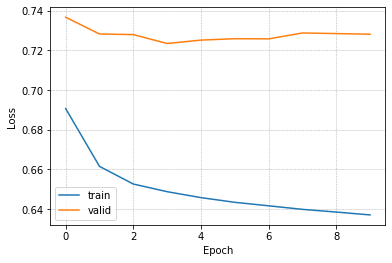

In [20]:
# train loop
plt.plot([np.mean(train_loss[epoch]) for epoch in train_loss], label='train')
plt.plot([np.mean(valid_loss[epoch]) for epoch in valid_loss], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend()


## tryout

In [22]:
y_hat = torch.Tensor([1, 2, 2.5, 0.7, 0, .4])
y     = torch.Tensor([1, 2, 3, 2, 1, 2])

In [46]:
y_hat

tensor([1.0000, 2.0000, 2.5000, 0.7000, 0.0000, 0.4000])

In [47]:
y

tensor([1., 2., 3., 2., 1., 2.])

In [42]:
indices = torch.where(y>z)
indices

(tensor([2]),)

In [43]:
y_hat[indices]

tensor([2.5000])

In [76]:
# loop over absolute differences
loss = 0
gamma = 1
for i, z in enumerate(y):
    indices = torch.where(y>z)[0]
    if len(indices) > 0:
        loss += torch.log(1 + torch.exp(-gamma * (y_hat[indices] - y_hat[i]))).sum()
    

Wall time: 1.99 ms


In [65]:
loss

tensor(4.2711)